# Clasificación de sentimientos con extracción de features manual
---

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.join(sys.path[0].split('BecaNLP')[0],'BecaNLP/Utils'))
import NLPUtils as nlp

%load_ext autoreload
%autoreload 2

## Introducción

En este notebook vamos a investigar la primera forma de hacer análisis de sentimientos, que consiste en decidir si un texto tiene una connotación positiva o negativa. A continuación vemos un ejemplo de cada uno de estos casos:

1. Positivo: "*I realize that alot of people hate this movie, but i must admit that it is one of my favorites. I happen to like it better then its predeccesor and happy to like it better than alot of movies. First off, I think that people never give the story any credit, much like Back to the Future, Time Travel is hard to write, and in this movie they included Time Travel and a Spiritual Journey.I also feel that Keanu and Alex were on there best performances in this movie, they looked cooler, acted cooler, and said cooler things. The set design of this movie is awsome as well, The sets are quite detailed and massive at times and it can be hard to believe that these sets were made for a movie about two teenage buds who can hardly spell...but isnt that the genius of the whole franchise, making these two idiots bigger than life characters that are responsible for the entire utopian future of earth. The costume design was awsome as well. Bill and Ted actually look cool in Bogus Journey, where as in Excellent Adventure they look rather like, well as they would put it, FAGS!!! Even the music in this movie is awsome, the score especially. There so much i could say about this film, cause i love it. But this is one of those movies i grew up watching and everytime i did i liked it more, so i can understand why people hate or just think its Bogus compared to Excellent adventure (which i also love by the way). GET DOWN WITH YOUR BAD SELF!!!!*"


2. Negativo: "*This is definitely the worst bigfoot movie I've ever seen and quite possibly the overall worst movie I've ever seen in my life. The actors and actresses were horrible and it seemed like they were trying way too hard to play their roles as dorks, tough guys, jerks, know it alls, etc. And the bigfoot itself was terrible. It appeared to be some kind of computer generated image from the days of Atari & Intellivision. At one point near the end of the movie as an army of sasquatches were chasing after the remaining survivors, one gets shot and as it's running it looked like a poor man's version of donkey kong himself! And one gets hit by a bullet and the blood that comes out of it was just awful animation. Another thing that was annoying was the music. Way way way too much music (classical score or whatever you call it) throughout the entire film. It was never ending. Oh yeah, the movie is boring too. Absolutely one of the worst films I've ever seen. I highly recommend taking your 3 USS or whatever they charge to rent this movie and spending it on a gallon of gas or a value menu somewhere. TRULY AWFUL!*"

Si bien este proceso ya es bastante complejo por sí mismo, esta tarea es una gran simplificación de el proceso de analizar sentimientos o emociones en un texto. Por lo general, no sólo se desea tomar una decisión en base a si "un texto es positivo o negativo", sino que muchas veces interesan cosas como:

* los diferentes grados de positividad o negativadad,
* los aspectos que aparecen en el texto y su correspondiente emotividad
* las causas por las cuales se calificó al texto como positivo o negativo

En este notebook, sin embargo, nos concentraremos en la tarea descrita en primer lugar. Concretamente, lo que queremos hacer es lo siguiente:

1. Representar un texto (comentario, exclamación, etc.) con un vector de características o *features* $\mathbf{x}\in \mathbb{R}^d$ que contenga la información suficiente como para determinar a qué clase pertenece el texto.

2. Definir un modelo que permita clasificar cualquier vector $\mathbf{x}$ obtenido de la manera anterior.

Esta es la forma clásica de encarar un problema con machine learning. Sin embargo, existen otros enfoques posibles que consisten en codificar al texto de manera que la extracción de features se realice de forma automática con el modelo. Estos modelos serán vistos más adelante.

## 1. Extracción de características

### Modelo de Bolsa de Palabras (*Bag of Words*)

El primer problema que enfrentamos para discriminar entre comentarios positivos y negativos es representar un texto con un vector. Para esto hay muchas formas, pero una de las más comunes y usadas como primera opción es la representación en **bolsa de palabras** o *bag of words* (BOW).

Este método consiste en definir un vocabulario de palabras $V=\{ w_1, w_2,\ldots, w_n\}$ y contar la cantidad de veces que apareció cada una de estas palabras en el texto. De esta manera, la $i$-ésima coordenada del vector $\mathbf{x}$ corresponde a la cantidad de veces que apareció la palabra $w_i$ en el texto.

Por ejemplo, supongamos que se tiene el siguiente texto:

```
<START> I am Sam. Sam I am. I do not like green eggs and ham. <END>
```

y se define un vocabulario `V = ['I', 'am', 'Sam', 'do', 'not', 'like', 'green', 'eggs', 'and', 'ham', '.', '<START>', '<END>']`. Entonces, el vector de features que representa el texto anterior es

$$
x = \begin{bmatrix}
count(I) \\
count(am) \\
count(Sam) \\
\vdots \\
count(.) \\
count(<START>) \\
count(<END>) 
\end{bmatrix}
=
\begin{bmatrix}
3 \\ 2 \\ 2 \\ \vdots \\ 3 \\ 1 \\ 1 
\end{bmatrix}
$$

Notemos varias cosas:

* Esta representación es equivalente a representar un histograma de las palabras de que aparecen en cada muestra.

* No se tiene en cuenta el orden en el que aparecen las palabras, por lo que se está perdiendo información (¡y muy valiosa!)

* Existen elementos del vocabulario, como el punto y los signos de comienzo y fin del texto, que no son palabras pero que, sin embargo, forma parte del texto. Esto se hace porque aportan información valiosa sobre el texto, y descartarlos, muchas veces disminuye el desempeño del algoritmo. Por otro lado, se verá que tener muchos componentes en el vocabulario también puede jugar en contra de la cantidad de aciertos. Es común denominar a los integrantes del vocabulario ***tokens*** cuando se refiere a los ejemplos de estos elementos en el texto, y ***types*** cuando se refieren a los elementos en sí.

* Existe la posibilidad de que en el texto aparezcan tokens (como por ejemplo `green`) que no forman parte del vocabulario. En este caso se suelen ignorar estas apariciones, aunque a veces se suele incorporar un token especial de tipo desconocido (representado como `<UNK>`) que contabilice las palabras que están fuera del vocabulario. En el caso de proceder de esta manera, el vocabulario se define como `V = ['I', 'am', 'Sam', 'do', 'not', 'like', 'green', 'eggs', 'and', 'ham', '.', '<START>', '<END>', '<UNK>']` y el vector del ejemplo tendrá una coordenada extra de valor 1, correspondiente a la cantidad de palabras fuera del vocabulario que aparecieron en el ejemplo (en este caso, `'green'`).

### Contando n-gramas

Un n-grama es una sucesión de n elementos pertenecientes al vocabulario $V$. Como alternativa al modelo BOW, suele implementarse por lo general una extracción de *features* que consiste en contar la cantidad de n-gramas que aparecen en el texto, siendo n un valor a decidir. 

Algunas observaciones:

* Vemos que el modelo de contar n-gramas para el caso en que $n=1$ es idéntico al modelo BOW.

* Muchas veces se suelen incluír varios valores de $n$ para la misma extracción de features. Es decir, por ejemplo para $n=1$ y $n=2$, el vector de *features* uncluye la cantidad de unigramas y bigramas que aparecieron en cada documento. Esto suele traer problemas de dispersión en las cuentas, que se solucionan de diferentes maneras, pero también ayudan a capturar relaciones entre palabras que no se obtienen fácilmente con el modelo BOW.

### El tamaño del vocabulario

En todos los casos que se extraen características de un texto con métodos frecuentistas, es necesario definir previamente un vocabulario $V$. Este paso tiene muchas variantes:

* Puede considerarse las $N$ palabras más frecuentes que aparecen en el texto de entrenamiento como vocabulario. Por lo genera, un vocabulario no baja de las 10000 palabras.

* Puede seleccionarse a través de un lexicon o un wordnet, ciertas palabras claves y tomar eso como como vocabulario. Para el caso de análisis de sentimientos suelen implementarse modelos que cuentan las palabras del campo semántico de las emociones. Sin embargo, esto implicaría agregar conocimiento previo al modelo.

* Muchas veces se suelen descartar palabras que aparecen muy frecuentemente y que no aportan información significativa al modelo. Palabras como *the*, *a*, *is*, *are*, etc. suelen descartarse a la hora de contar n-gramas, y se conocen como **Stop Words**.

* Lo que más se suele hacer, sin embargo, (y que además es lo que menos costo computacional tiene) es considerar como palabras del vocabulario a todos los n-gramas del conjunto de entrenamiento. Es decir, sin agregar información previa al modelo.

* El proceso de tokenización es importante en este caso porque cambia, a veces, significativamente la cantidad de palabras en el vocabulario. Lo más común es utilizar *regular expressions* para esto y no agregar modificaciones que impliquen *lemmatization* o *stemming*. 

Todas estas variantes son importantes e influyen bastante en el resultado final, pero es importante tener en cuenta que lo más importante es tener experimentos consistentes. Es decir, yo puede tomar diferentes formas de tokenización, pero a la hora de sacar conclusiones tengo que comparar dos modelos con iguales condiciones de definición del vocabulario. 

### Caso práctico: inspección del modelo BOW en  el IMDb dataset

El dataset IMDb consiste en un conjunto de reviews de películas, es decir que cada muestra contiene un comentario sobre una película (una cadena de caracteres) y su respectiva calificación en una escala de valores de `1` a `10`. 

In [2]:
import NLPUtils.datasets.imdb as imdb

df_train = imdb.train_reader()
df_train.head(10)

,comment,rate
13701,Louis Sachar's compelling children's classic i...,10
23820,"For quite a long time in my life, I either did...",8
11397,The original Thunderbirds earned a place in TV...,3
4178,"This is a ripsnorting, old-fashioned adventure...",10
7828,"If you came into the film with expectations, t...",10
13175,This installment very much makes the CIA look ...,8
22,hi.. I consider Just Cause one of my favorite ...,10
709,The 1997 low-key indie dramedy Henry Fool woul...,7
15290,Stumbling upon this HBO special late one night...,10
13028,I have copies of both these Movies the classic...,10


En este caso vamos a querer representar los textos como una bolsa de n-gramas. Además, para simplificar la tarea, vamos a considerar que todas las clases con una puntuación mayor a 6 fueron positivas, mientras que las que tienen menor a 5 fueron negativas.

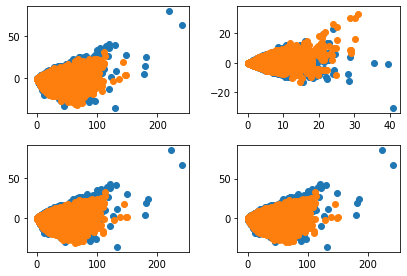

In [90]:
from NLPUtils.datasets import imdb
from NLPUtils.vsm import reduce_to_k_dim

def get_binary_count_dataset(df,vocab,token_pattern,ngram_range):
    data = imdb.count_ngrams_and_vectorize(df,dev_size=0,k_folds=None,
                                      random_state=0,labels_func=None,
                                      vocabulary=vocab,token_pattern=token_pattern,
                                      ngram_range=ngram_range)
    X, y = data['train']
    y[y < 5] = 0
    y[y > 6] = 1
    return X, y


def plot_bows(X,y,ax=None,transform=None):
    
    if ax is None:
        fig, ax = plt.subplots()
    
    if transform is None:
        transform = lambda x: x
        
    reduced_X = reduce_to_k_dim(transform(X),k=2)
    reduced_pos_comments = reduced_X[y == 1]
    reduced_neg_comments = reduced_X[y == 0]
    
    ax.scatter(reduced_pos_comments[:,0],reduced_pos_comments[:,1])
    ax.scatter(reduced_neg_comments[:,0],reduced_neg_comments[:,1])
    
    
# Graficamos los vectores reducidos en dimensión para diferentes N-gramas
    
#vocab = imdb.vocab_file_reader() # Palabras del vocabulario
vocab = None
token_pattern = r'\b\w+\b' # Tokenización 
df_train = imdb.train_reader()#.sample(n=100, replace=False, random_state=12636)

fig, ax = plt.subplots(2,2)
fig.tight_layout()
for i, ngram_range in enumerate([(1,1), (2,2), (1,2), (1,3)]):
    X, y = get_binary_count_dataset(df_train,vocab,token_pattern,ngram_range)
    plot_bows(X,y,ax=ax[i//2,i%2],transform=None)

### Reponderamiento

También podemos ver si la representación cambia con los métodos de reponderamiento. Es decir, dada una matriz de muestras en sus filas, un reponderamiento de sus índices corresponde a una nueva distribución de dichas muestras. 

Métodos a considerar:

* Normalización por filas y por columnas
* PPMI
* Tf-Idf

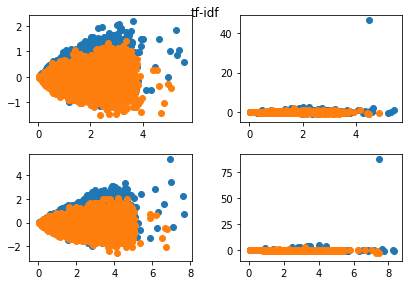

In [93]:
from scipy.sparse import csr_matrix

def tfid_transform(X,smooth=True):
    tf = csr_matrix((np.log10(X.data+1),X.indices,X.indptr))
    idf = np.log10(X.shape[0] / np.array((X != 0).sum(axis=0)).reshape(-1))
    return tf.multiply(idf)

def pmi_transform(comments_bow):
    return comments_bow

def oe_transform(comments_bow):
    return comments_bow

for transform, name in zip([tfid_transform],['tf-idf']):#, pmi_transform, oe_transform]
    fig, ax = plt.subplots(2,2)
    fig.tight_layout()
    fig.suptitle(name)
    for i, ngram_range in enumerate([(1,1), (2,2), (1,2), (1,3)]):
        X, y = get_binary_count_dataset(df_train,vocab,token_pattern,ngram_range)
        plot_bows(X,y,ax=ax[i//2,i%2],transform=transform)

### Inspección para diferentes vocabularios

Podemos variar el tamaño del vocabulario y ver si la representación varía en algo

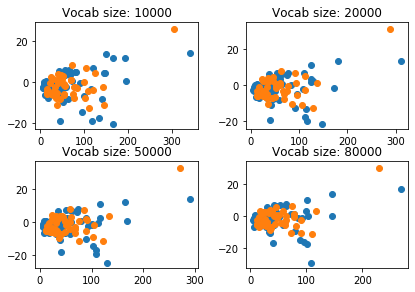

In [8]:
include_unk = True 
include_startend = True 
    
vocab_sizes = [10000, 20000, 50000, 80000]
n_columns = 1
n_filas = int(np.ceil(len(vocab_sizes)/n_columns))
fig, ax = plt.subplots(n_filas,n_columns)
fig.tight_layout()

for i, N_vocab in enumerate(vocab_sizes):
    
    dataset = BinaryBOWDataset.split(dev_size=.1, 
                                     vocab=N_vocab, 
                                     test=False, 
                                     include_unk=include_unk, 
                                     include_startend=include_startend, 
                                     in_dtype=torch.float, 
                                     out_dtype=torch.long)
    
    comments_bow = np.array(dataset['train'].x).astype(np.float)
    labels = np.array(dataset['train'].y).astype(np.int)
    
    try:
        plot_reduced_bows(comments_bow,labels,ax=ax[i//n_columns,i%n_columns],transform=None)
        ax[i//n_columns,i%n_columns].set_title('Vocab size: {}'.format(N_vocab))
    except TypeError:
        plot_reduced_bows(comments_bow,labels,ax=ax,transform=None)
        ax.set_title('Vocab size: {}'.format(N_vocab))

## 2. Clasificación

A continuación vamos a obtener un sistema para clasificar muestras como las obtenidas anteriormente. Para ello vamos a estudiar el método de Regresión Logística y el algoritmo de Naive Bayes.

### Logistic Regression

El modelo de regresión logística es un modelo discriminativo que forma parte de la familia de modelos discriminativos paramétricos conocida como **Modelos Lineales Generalizados** (*Generalized Linear Models*, GLM). Un modelo de este tipo puede construirse de la siguiente manera:

1. Se define que la variable aleatoria $y|\mathbf{x}$ que relaciona la entrada con la salida depende de un conjunto de parámetros $\theta$ y pertenece a la familia de exponenciales de parámetro $\eta$ de tal manera que $\eta = \theta^T \mathbf{x}$. Esto es:

$$
\begin{align*}
y|\mathbf{x} &\sim \mathrm{ExpFamily}\left(\eta\right) \\[.5em]
P(y|\mathbf{x}) &= b(y)\exp\left( \eta^T y - a\left(\eta\right)\right) \\[.5em]
P(y|\mathbf{x};\theta) &= b(y)\exp\left( \mathbf{x}^T \theta y - a(\theta^T \mathbf{x})\right)
\end{align*}
$$

2. La salida del modelo se obtiene por medio de

$$
h_\theta(\mathbf{x}) = E\left[ y|\mathbf{x}\right]
$$

El modelo de regresión logistica consiste en definir la probabilidad a posteriori 

$$
P(y|\mathbf{x};\theta) = \sigma\left( \theta^T \mathbf{x} \right)^y \left( 1 - \sigma\left( \theta^T \mathbf{x} \right) \right)^{(1-y)}
$$

donde 

$$
\sigma(z) = \frac{1}{1+ e^{-z}}
$$ 

y puede mostrarse que forma parte de los modelos GLM para el caso en que $T(y)=y$, $b(y)=1$ y $a(\theta^T\mathbf{x})=\log\left(1+e^{\theta^T\mathbf{x}}\right)$. 

También puede verse que 

$$
h_\theta(\mathbf{x}) = E\left[ y|\mathbf{x}\right] = P(y=1|\mathbf{x};\theta)\cdot 1 + P(y=0|\mathbf{x};\theta)\cdot 0 = \sigma\left( \theta^T \mathbf{x} \right)
$$

por lo que la salida del modelo da la probabilidad de pertenecer a la clase $y=1$, y por lo tanto, aporta todo lo necesario para realizar una nueva predicción.

En lo que sigue, adoptaremos el criterio de **máxima verosimilitud** para estimar los parámetros del modelo. De esta forma:

$$
\begin{align*}
\hat{\theta} &= \mathrm{argmax}_\theta \prod_{i=1}^N P\left(y^{(i)}|\mathbf{x}^{(i)};\theta\right) \\
&= \mathrm{argmax}_\theta \prod_{i=1}^N \sigma\left( \theta^T \mathbf{x}^{(i)} \right)^{y^{(i)}} \left( 1 - \sigma\left( \theta^T \mathbf{x}^{(i)} \right) \right)^{(1-y^{(i)})}\\
&= \mathrm{argmax}_\theta \log\left(\prod_{i=1}^N \sigma\left( \theta^T \mathbf{x}^{(i)} \right)^{y^{(i)}} \left( 1 - \sigma\left( \theta^T \mathbf{x}^{(i)} \right) \right)^{(1-y^{(i)})}\right)\\
&= \mathrm{argmax}_\theta \sum_{i=1}^N y^{(i)} \log\left(\sigma\left( \theta^T \mathbf{x}^{(i)} \right)\right) + \left(1 - y^{(i)}\right) \log\left(1 - \sigma\left( \theta^T \mathbf{x}^{(i)} \right)\right)\\
\end{align*}
$$

In [103]:
from NLPUtils.classifiers import LogisticRegressionClassifier as LR
import torch
from torch.utils.data import Dataset

class BinaryIMDbDataset(Dataset):
    
    def __init__(self,X,y,transform=None):
        if transform is None:
            transform = lambda x: x
        self.X = transform(X)
        self.y = torch.tensor(y).type(torch.float).view(-1,1)
        
    def __getitem__(self,idx):
        x = torch.tensor(self.X[idx,:].toarray(),dtype=torch.float).view(-1)
        y = self.y[idx]
        return x, y
    
    def __len__(self):
        return len(self.y)
    
token_pattern = r'\b\w+\b'
df_train = imdb.train_reader()

def binarize(y):
    y[y < 5] = 0
    y[y > 6] = 1
    return y

data = imdb.count_ngrams_and_vectorize(df_train,dev_size=.2,k_folds=None,
            random_state=0,labels_func=binarize,vocabulary=None,token_pattern=token_pattern)
train_dataset = BinaryIMDbDataset(data['train'][0],data['train'][1],tfid_transform)
dev_dataset = BinaryIMDbDataset(data['dev'][0],data['dev'][1],tfid_transform)

in_features = train_dataset.X.shape[1]
classifier = LR(in_features,bias=True,device='cpu')

/home/lestien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


ValueError: inconsistent shapes

In [101]:
classifier.train(train_dataset, 
                 optim_algorithm='SGD', 
                 epochs=1,
                 batch_size=512,
                 lr=1e-3)

Starting training...
Epoch 1 finished. Approximate loss: 0.6848
Training finished



In [102]:
classifier.predict(dev_dataset)

Total accuracy: 2996/5000 (59.92%)


### Modelo Feed-Froward con Logistic Regression

Otra opción es agregar un layer intermedio entre la entrada y la salida.

In [12]:
from NLPUtils.classifiers import TwoLayerLRNet

class BinaryReducedIMDbDataset(Dataset):
    
    def __init__(self,df,vectorizer,k):
        x = vectorizer.transform(df['comment'])
        self.comments_bow = torch.tensor(reduce_to_k_dim(x,k=k),dtype=torch.float)
        self.labels = torch.tensor(df['rate'].values.copy(),dtype=torch.float).view(-1,1)
        self.labels[self.labels < 5] = 0
        self.labels[self.labels > 6] = 1
        
    def __getitem__(self,idx):
        x = self.comments_bow[idx,:]
        y = self.labels[idx]
        return x, y
    
    def __len__(self):
        return len(self.labels)

vectorizer = get_vectorizer(df_train,vocab,token_pattern,ngram_range=(1,1))
k = 100
train_dataset = BinaryReducedIMDbDataset(df_train,vectorizer,k)
dev_dataset = BinaryReducedIMDbDataset(df_dev,vectorizer,k)

in_features = train_dataset.comments_bow.shape[1]
hidden_features = 200
classifier = TwoLayerLRNet(in_features,hidden_features,bias=True,device='cpu')

In [13]:
classifier.train(train_dataset, 
                 optim_algorithm='SGD', 
                 epochs=20,
                 batch_size=512,
                 lr=1e-3)
classifier.predict(dev_dataset)

Starting training...
Epoch 1 finished. Approximate loss: 0.7119
Epoch 2 finished. Approximate loss: 0.7096
Epoch 3 finished. Approximate loss: 0.6988
Epoch 4 finished. Approximate loss: 0.6955
Epoch 5 finished. Approximate loss: 0.6820
Epoch 6 finished. Approximate loss: 0.6778
Epoch 7 finished. Approximate loss: 0.6684
Epoch 8 finished. Approximate loss: 0.6793
Epoch 9 finished. Approximate loss: 0.6702
Epoch 10 finished. Approximate loss: 0.6753
Epoch 11 finished. Approximate loss: 0.6609
Epoch 12 finished. Approximate loss: 0.6631
Epoch 13 finished. Approximate loss: 0.6606
Epoch 14 finished. Approximate loss: 0.6640
Epoch 15 finished. Approximate loss: 0.6614
Epoch 16 finished. Approximate loss: 0.6420
Epoch 17 finished. Approximate loss: 0.6591
Epoch 18 finished. Approximate loss: 0.6360
Epoch 19 finished. Approximate loss: 0.6416
Epoch 20 finished. Approximate loss: 0.6435
Training finished

Total accuracy: 2183/5000 (43.66%)


In [14]:
classifier.train(train_dataset, 
                 optim_algorithm='SGD', 
                 epochs=20,
                 batch_size=512,
                 lr=1e-3)
classifier.predict(dev_dataset)

Resuming training from epoch 21...
Epoch 21 finished. Approximate loss: 0.6431
Epoch 22 finished. Approximate loss: 0.6339
Epoch 23 finished. Approximate loss: 0.6262
Epoch 24 finished. Approximate loss: 0.6528
Epoch 25 finished. Approximate loss: 0.6245
Epoch 26 finished. Approximate loss: 0.6324
Epoch 27 finished. Approximate loss: 0.6238
Epoch 28 finished. Approximate loss: 0.6237
Epoch 29 finished. Approximate loss: 0.6257
Epoch 30 finished. Approximate loss: 0.6320
Epoch 31 finished. Approximate loss: 0.6449
Epoch 32 finished. Approximate loss: 0.6155
Epoch 33 finished. Approximate loss: 0.6294
Epoch 34 finished. Approximate loss: 0.6321
Epoch 35 finished. Approximate loss: 0.6058
Epoch 36 finished. Approximate loss: 0.6194
Epoch 37 finished. Approximate loss: 0.6153
Epoch 38 finished. Approximate loss: 0.6183
Epoch 39 finished. Approximate loss: 0.6137
Epoch 40 finished. Approximate loss: 0.6150
Training finished

Total accuracy: 2151/5000 (43.02%)


### Naive Bayes

Este modelo pertenece a la familia de **modelos generativos**, los cuales (a grandes rasgos) modelan la forma en cómo se generan los datos. De esta forma, el método de decisión bayesiano que consiste en decidir por la clase que tiene máxima probabilidad a posteriori

$$
\hat{\mathcal{C}} = \mathrm{argmax}_{k} P(\mathcal{C}_k|\mathbf{x})
$$

puede reescribirse utilizando la regla de Bayes de la siguiente manera:

$$
\begin{align*}
\hat{\mathcal{C}} &= \mathrm{argmax}_{k} P(\mathcal{C}_k|\mathbf{x}) \\[.5em]
& = \mathrm{argmax}_{k} \frac{P(\mathbf{x}|\mathcal{C}_k)P(\mathcal{C}_k)}{P(\mathbf{x})} \\[.5em]
& = \mathrm{argmax}_{k} P(\mathbf{x}|\mathcal{C}_k)P(\mathcal{C}_k)
\end{align*}
$$

de manera que pueden modelarse las probabilidades $P(\mathbf{x}|\mathcal{C}_k)$ y $P(\mathcal{C}_k)$ por separado, y utilizarse para estimar la probabilidad $P(\mathcal{C}_k|\mathbf{x})$. 

Por otra parte, para el caso en que el espacio de features $\mathbb{R}^d$ tiene una dimensión muy grande, hacer un modelo discriminativo para clasificación suele tener que implicar una gran cantidad de parámetros. Por eso, se suele asumir la independencia condicional de los features entre sí:

$$
\begin{align*}
P(\mathbf{x}|\mathcal{C}_k) &= P(x_1,\ldots,x_n|\mathcal{C}_k)\\[.5em]
&= P(x_1|\mathcal{C}_k),\ldots,P(x_m|\mathcal{C}_k)\\[.5em]
&= \prod_{j=1}^m P(x_i|\mathcal{C}_k)\\[.5em]
\end{align*}
$$

de manera que las únicas probabilidades a modelar y a estimar sean $P(x_i|\mathcal{C}_k)$ para y $P(\mathcal{C}_k)$ $k\in \{ 0, 1\}$. 

Una forma muy común de modelar $P(x_i|\mathcal{C}_k)$ es a través de una distribución Bernoulli de parámetro $\phi_{i|k}$ que representa la probabilidad de que la palabra $w_i$ haya aparecido en la bolsa de palabras $\mathbf{x}$, dado que se obtuvo la clase $\mathcal{C}_k$. Es decir:

$$
P(\mathbf{x}|\mathcal{C}_k) = \phi_{i|k}
$$

Aplicando máxima verosimilitud, pueden obtenerse el valor de estos parámetros:

$$
\begin{align*}
LL &=  \sum_{i=1}^N \log\left(P(\mathbf{x}^{(i)}|y^{(i)})P(y^{(i)})\right) \\[.5em]
&=  \sum_{i=1}^N \log\left(P(\mathbf{x}^{(i)}|y^{(i)})\right) + \log\left(P(y^{(i)})\right) \\[.5em]
&=  \sum_{i=1}^N \log\left(\prod_{j=1}^m P(x_j^{(i)}|y^{(i)})\right) + \log\left(P(y^{(i)})\right) \\[.5em]
&=  \sum_{i=1}^N \sum_{j=1}^m \log\left(P(x_j^{(i)}|y^{(i)})\right) + \log\left(P(y^{(i)})\right) \\[.5em]
&=  \sum_{i=1}^N \sum_{j=1}^m \log\left(\phi_{j|k=0}\mathbb{1}_{\{ y^{(i)} = 0 \}} + \phi_{j|k=1}\mathbb{1}_{\{ y^{(i)} = 1 \}}\right)  + \log\left(P(y^{(i)})\right) \\[.5em]
\end{align*}
$$

$$
\begin{align*}
\phi_{j|k=0} &=  \frac{\sum_{i=1}^N \mathbb{1}_{\{ x_j^{(i)}>0 \;\wedge\; y^{(i)} = 0\}} }{\sum_{i=1}^N \mathbb{1}_{\{ y^{(i)} = 0\}}}\\[.5em]
\phi_{j|k=1} &=  \frac{\sum_{i=1}^N \mathbb{1}_{\{ x_j^{(i)}>0 \;\wedge\; y^{(i)} = 1\}} }{\sum_{i=1}^N \mathbb{1}_{\{ y^{(i)} = 1\}}}\\[.5em]
\phi_{k} &=  \frac{\sum_{i=1}^N \mathbb{1}_{\{ y^{(i)} = 1\}} }{N}
\end{align*}
$$